# NEURON tutorial: Ball-and-stick electrical model with synapse

## Introduction

In this tutorial we will give an introduction to the NEURON simulator. You will learn how to:
* **Load** the simulator in Python
* Construct a **single compartmental electrical** model
* **Run a simulation**, record the membrane voltage of the model and inject an external current
* **Add ion channels** to the membrane of the model
* Extend the model with a simple **dendrite**
* **Add a synapse** to the model
* **Connect** two cells

## Loading the NEURON simulator

We first import the NEURON Python module and a standard library with some convenient functionality

In [3]:
import neuron

Historically the NEURON simulator was controlled using the [HOC language](https://www.neuron.yale.edu/neuron/static/new_doc/programming/hocsyntax.html).
More and more scientists are switching to the Python interface of NEURON. In Python there is something called the [HOCObject](https://www.neuron.yale.edu/neuron/static/docs/help/neuron/neuron/classes/python.html#HocObject) which be accessed by 'h' property of the neuron module, and which contains the HOC functionality of NEURON. For example, to load the 'stdrun.hoc' file which contains some handy functionality one calls the HOC function load_file using:

In [4]:
print neuron.h
# Load external files
neuron.h.load_file("stdrun.hoc");

To make sure we start from a clean state we initialise the simulator

In [5]:
neuron.h.stdinit();

It is important to know that all the values used in NEURON have a certain default unit. 
The list of the defaults can be accessed here: https://www.neuron.yale.edu/neuron/static/docs/units/unitchart.html

For now the most important ones are:
* **length**: micrometer (um)
* **time**: milliseconds (ms)
* **voltage**: millivolt (mV)
* **capacitance**: microfarad/cm2 (uf/cm2)

## Constructing a neuron consisting of one compartment

The basic structure of a cell in NEURON is a set of interconnected cylinders (called segments or compartments). Each of these cylinders represents an isopotential part of the cell.

**Drawing of a set of compartments**

*Add drawing -> 1 segment -> 5 segments (how to address them)* ?

The segments between the branch points are grouped together in sections. The soma of a cell is in general one section of the cell.
Let's start with creating a cell with just a soma:

In [6]:
soma = neuron.h.Section(name='soma')

print "Soma object:", soma
print "Soma object name: ", soma.name()

print "Number of segments in the soma:", soma.nseg

Soma object: <nrn.Section object at 0x10b77fa30>
Soma object name:  soma
Number of segments in the soma: 1


In [7]:
# 3D coordinates are not important for ephys
# Show how to change 3d points ?

# everything neuron in cylinder -> also soma (is a section by design) !
# surface is most important
# mostly talking about currents through surface

# explain sec= ...

As we know the soma is represented as a cylinder. We can set the length and diameter of this section.

In [8]:
soma.L = 40
soma.diam = 40
print "Soma length: %f micron" % soma.L 
print "Soma diameter: %f micron" % soma.diam

# plot this in some way

Soma length: 40.000000 micron
Soma diameter: 40.000000 micron


We can calculate the surface area of the soma using the 'area()' function, and compare it to the equation to calculate the surface area of a cylinder:

In [9]:
soma_area_eq = 2 * neuron.h.PI * soma.L * soma.diam / 2
print "Soma area according to cylinder surface area equation: %f micron^2" % soma_area_eq

soma_area = neuron.h.area(0.5, sec=soma)
print "Soma area according to NEURON: %f micron^2" % soma_area

print "Both values match: %s" % (soma_area_eq == soma_area)

Soma area according to cylinder surface area equation: 5026.548246 micron^2
Soma area according to NEURON: 5026.548246 micron^2
Both values match: True


In general the soma of a neuron is rather spherical than cylindrical. You might have found it strange that we represent the soma by a cylinder in NEURON. However, the following equation shows that it actually doesn't really matter, the surface area of a sphere with the same radius is exactly the same:

In [10]:
soma_sphere_area_eq = 4 * neuron.h.PI * pow(soma.diam / 2, 2)
print "Soma area according to sphere surface area equation: %f micron^2" % soma_sphere_area_eq

Soma area according to sphere surface area equation: 5026.548246 micron^2


So now we have defined the shape of this single compartmental cell. Electrically the only component that is present for now is the [capacitance](https://en.wikipedia.org/wiki/Capacitance) of the cell membrane. We can retrieve or set the specific membrane capacitance by accessing the 'cm' field. 

In [11]:
# Units are mostly per surface area
# uf/cm2
print "Specific capacitance: %f uf/cm2" % soma.cm

Specific capacitance: 1.000000 uf/cm2


To get the total capacitance of the soma, we have to multiply this by the area. We have to be careful with the units though !

In [12]:
soma_tcap = (soma.cm * (soma_area / pow(1e4, 2)))
print "Total soma capacitance: %f uf" % (soma.cm * (soma_area / pow(1e4, 2)))

Total soma capacitance: 0.000050 uf


## Running a simulation

Let's now run a simulation over time. We will record the [membrane voltage](https://en.wikipedia.org/wiki/Membrane_potential) in the middle of the soma during the simulation:

In [13]:
print "Membrane voltage soma: %f mV" % soma(.5).v # mV

Membrane voltage soma: -65.000000 mV


As you can see the voltage of the cell has been initialised to -65 mV, which roughly corresponds to a typical value in neurons at rest (also called the *resting membrane potential*).

The simulator will integrate the equations over time. The current time is saved in a variable called 't':

In [14]:
print "Current time: %f ms" % neuron.h.t # ms

Current time: 0.000000 ms


When the run() function is called, the simulation will run until a predefined time stored in the the 'tstop' variable. Every timestep, defined by 'dt', a new voltage value will be calculated. 

In [15]:
# Explain tstop
neuron.h.tstop = 100
print "Simulation stop time: %f ms" % neuron.h.tstop
print "Integration time step: %f ms" % neuron.h.dt

Simulation stop time: 100.000000 ms
Integration time step: 0.025000 ms


To record the time and voltage we create two NEURON Vector objects. These objects have a 'record' method that, when passed a reference to a variable, will record the value of that variable in the vector during the simulation.

In [16]:
time = neuron.h.Vector()
voltage = neuron.h.Vector()

time.record(neuron.h._ref_t)
voltage.record(soma(.5)._ref_v);

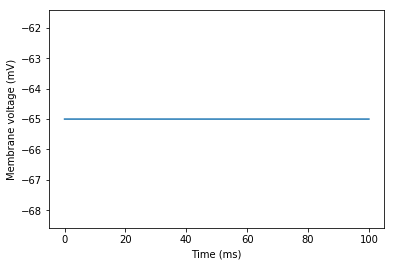

In [17]:
neuron.h.run()

# Convert the NEURON vectors to numpy arrays
time_py = time.to_python()
voltage_py = voltage.to_python()

def plot_tv(time_array, voltage_array, show=True, label=None):
    import matplotlib.pyplot as plt
    plt.plot(time_array, voltage_array, label=label)
    plt.xlabel('Time (ms)')
    plt.ylabel('Membrane voltage (mV)')
    if show:
        plt.show()
    
plot_tv(time_py, voltage_py)

So, basically the voltage has stayed the same over time. We can see why this happened by looking at the following equation NEURON is integrating:

$$C_{m} dV/dt = I_{m}$$

Basically the change in voltage is related to the current going across the membrane. Since we don't have any mechanisms that allow currents to cross the membrane, $I_{m}$ is zero, and our voltage stay the same:

$$dV = I_{m} dt/C_{m}$$

## Injecting a current

Let's now see how we can charge the cell membrane capacitance. For this we stick a virtual electrode in the center of the soma, and inject current using a [current clamp](https://en.wikipedia.org/wiki/Electrophysiology#Current_clamp). We specify an amplitude (in nA), a delay and a duration for our stimulus.

In [18]:
# Add figure ?
iclamp = neuron.h.IClamp(.5, sec=soma)
iclamp.amp = 0.1 # nA
iclamp.delay = 10 # ms
iclamp.dur = 50 # ms

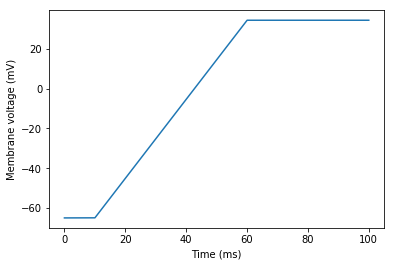

In [19]:
neuron.h.run()

# Convert the NEURON vectors to numpy arrays
time_py = time.to_python()
voltage_py = voltage.to_python()

plot_tv(time_py, voltage_py)

Let's check if this is the value we expected from the equation

$$C_{m} dV/dt = I_{m}$$

In [20]:
V1 = -65 # Voltage before stimulus, mV
V2 = soma.v # Voltage after stimulus, mV
deltaV = V2 - V1 # Voltage difference, mV
Im = iclamp.amp # nA
deltaT = iclamp.dur # ms
soma_tcap # total soma membrane capacitance, uF

deltaV_eq = Im * deltaT / soma_tcap # in nA * ms / uF == microvolt
deltaV_eq /= 1e3 # Correction factor to get mV

print 'Observed dV: %f mV' % deltaV
print 'Calculated dV: %f mV' % deltaV_eq
print 'Simulated dV matches equation dV: %s' % (deltaV - deltaV_eq < 1e-6)

Observed dV: 99.471839 mV
Calculated dV: 99.471839 mV
Simulated dV matches equation dV: True


## Adding a leak conductance

We'll now start adding transmembrane currents to the model as described in the [Hodgkin-Huxley model](https://en.wikipedia.org/wiki/Hodgkin–Huxley_model).
To enable the equations for this model, we insert the 'hh' mechanism in the soma:

In [22]:
soma.insert('hh');

Now NEURON will integrate the following equation to get calculate the membrane voltage over time:

$$C_{m} dV/dt = I_{Na} + I_{K} + I_{leak} + I_{ext} = g_{Na}(V)*(V - E_{Na}) + g_{K}(V)*(V - E_{K}) + g_{leak}*(V - E_{leak}) + I_{ext}$$

We have a sodium and potassium current with voltage dependent conductance and a leakage current with a voltage independent conductance.

Initially we'll set the Na and K conductance to zero:

In [24]:
soma.gkbar_hh = 0.0
soma.gnabar_hh = 0.0

So we get:

$$C_{m} dV/dt = g_{leak}*(V - E_{leak}) + I_{ext}$$

The value for the leak conductance is set using the 'gl_hh' attribute. 

In [25]:
soma.gl_hh = 5e-4 # Leak conductance, S/cm^2

In [ ]:
soma.el_hh = -65 # Reversal potential leak current, mV

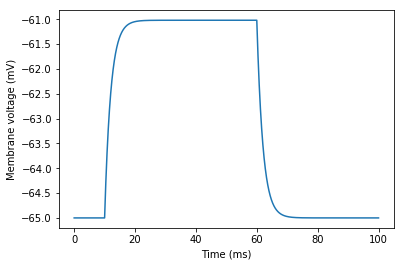

In [20]:
# explain reversal potential
# leak current 'fights' current injection
# explain 'hh'
# add question: which change do you see ?
# explain graph: doesn't go as high, shape different, and goes back reversal potential after injection
# exercise -> show how final voltage is calculated ?

# Add tstop everywhere (or add reset function)

neuron.h.tstop = 100


neuron.h.run()

# Convert the NEURON vectors to numpy arrays
time_py = time.to_python()
voltage_py = voltage.to_python()

plot_tv(time_py, voltage_py)

# Adding active ion channels

50.0
-77.0


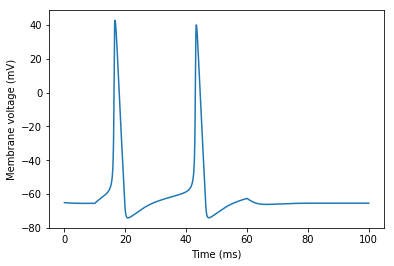

In [21]:
print soma.ena # explain e_na
print soma.ek

# For every addition of mechanism create figure show newer model
# Lines for reversal potentials Na, K and leak

soma.gkbar_hh = 0.01
soma.gnabar_hh = 0.1

neuron.h.run()

# Convert the NEURON vectors to numpy arrays
time_py = time.to_python()
voltage_py = voltage.to_python()

plot_tv(time_py, voltage_py)

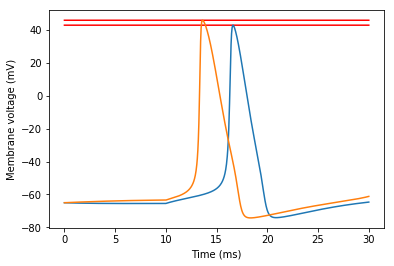

In [22]:
import matplotlib.pyplot as plt
import numpy


soma.gkbar_hh = 0.01
soma.gnabar_hh = 0.1

neuron.h.tstop=30

neuron.h.run()

# Convert the NEURON vectors to numpy arrays
time_py = time.to_python()
voltage_py = voltage.to_python()

plt.plot(time_py, max(voltage_py)*numpy.ones(len(time_py)), 'r')
plot_tv(time_py, voltage_py, show=False)

soma.gnabar_hh = 0.15

neuron.h.run()

# Convert the NEURON vectors to numpy arrays
time_py = time.to_python()
voltage_py = voltage.to_python()


plt.plot(time_py, max(voltage_py)*numpy.ones(len(time_py)), 'r')

plot_tv(time_py, voltage_py)

## Parameter sensitivity

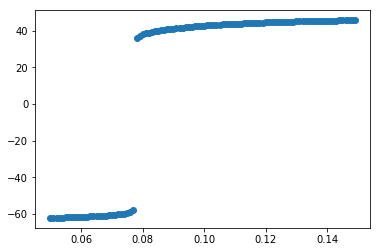

In [23]:
soma.gkbar_hh = 0.01

# definitely mention critical value where state changes
# show something with percentages
# show value we were using before on plot

max_voltages = []
import numpy
gnabar_range = numpy.arange(.05, 0.15, 0.001)
for gnabar in gnabar_range:
    soma.gnabar_hh = gnabar

    neuron.h.run()

    # Convert the NEURON vectors to numpy arrays
    time_py = time.to_python()
    voltage_py = voltage.to_python()
    
    max_voltages.append(max(voltage_py))

plt.plot(gnabar_range, max_voltages, 'o')
plt.show()

# Exercise

Do the same as above with K

Linear equation max_voltage = -451.860461*gkbar + 47.203047


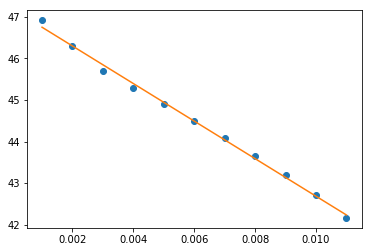

In [24]:
soma.gnabar_hh = 0.1

max_voltages = []
gkbar_range = numpy.arange(.001, 0.012, 0.001)
import numpy
for gkbar in gkbar_range:
    soma.gkbar_hh = gkbar

    neuron.h.run()

    # Convert the NEURON vectors to numpy arrays
    time_py = time.to_python()
    voltage_py = voltage.to_python()
    
    max_voltages.append(max(voltage_py))

plt.plot(gkbar_range, max_voltages, 'o')

linear_coef = numpy.polyfit(gkbar_range, max_voltages, 1)
print 'Linear equation max_voltage = %f*gkbar + %f' % tuple([x for x in linear_coef])

plt.plot(gkbar_range, numpy.poly1d(linear_coef)(gkbar_range))

plt.show()

In [25]:
dend = neuron.h.Section(name='dend')

In [26]:
dend.L = 400
dend.diam = 2.0
dend.nseg = 10

dend.connect(soma)


50.0
-77.0


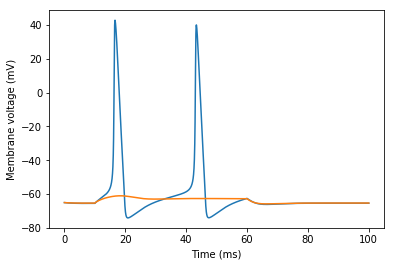

In [27]:
print soma.ena # explain e_na
print soma.ek

# For every addition of mechanism create figure show newer model
# Lines for reversal potentials Na, K and leak
neuron.h.tstop = 100

soma.gkbar_hh = 0.01
soma.gnabar_hh = 0.1

neuron.h.disconnect(sec=dend)


neuron.h.run()

# Convert the NEURON vectors to numpy arrays
time_py = time.to_python()
voltage_py = voltage.to_python()

plot_tv(time_py, voltage_py, show=False)

soma.gkbar_hh = 0.01
soma.gnabar_hh = 0.1

dend.connect(soma)

dend.insert('hh')
dend.el_hh = -65 # Reversal potential leak current, mV
dend.gl_hh = 5e-4 # Leak conductance, S/cm^2


dend.gkbar_hh = 0.0
dend.gnabar_hh = 0.0

neuron.h.run()

# Convert the NEURON vectors to numpy arrays
time_py = time.to_python()
voltage_py = voltage.to_python()

plot_tv(time_py, voltage_py)

50.0
-77.0
35.4


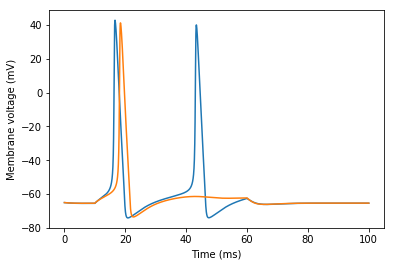

In [28]:
# Extra: What can you do to save the AP in the soma ?

print soma.ena # explain e_na
print soma.ek

# For every addition of mechanism create figure show newer model
# Lines for reversal potentials Na, K and leak
neuron.h.tstop = 100

soma.gkbar_hh = 0.01
soma.gnabar_hh = 0.1

neuron.h.disconnect(sec=dend)


neuron.h.run()

# Convert the NEURON vectors to numpy arrays
time_py = time.to_python()
voltage_py = voltage.to_python()

plot_tv(time_py, voltage_py, show=False)

soma.gkbar_hh = 0.01
soma.gnabar_hh = 0.1

dend.connect(soma)

dend.insert('hh')
dend.el_hh = -65 # Reversal potential leak current, mV
dend.gl_hh = 5e-4 # Leak conductance, S/cm^2


dend.gkbar_hh = 0.0
dend.gnabar_hh = 0.0

print dend.Ra
dend.Ra = 500

neuron.h.run()

# Convert the NEURON vectors to numpy arrays
time_py = time.to_python()
voltage_py = voltage.to_python()

plot_tv(time_py, voltage_py)


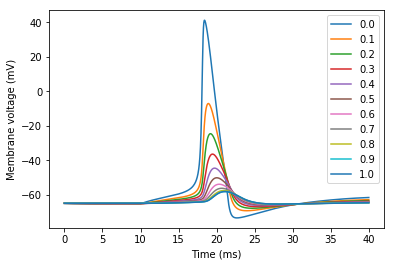

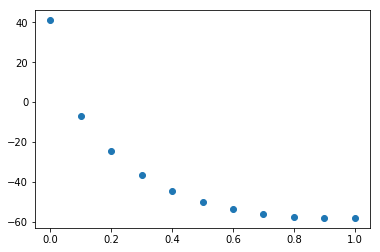

In [29]:
voltage_dend = {}
distance_range = numpy.arange(0, 1.1, 0.1)
for distance in distance_range:
    voltage_dend[distance] = neuron.h.Vector()
    voltage_dend[distance].record(dend(distance)._ref_v);
 
neuron.h.tstop = 40
neuron.h.run()

voltage_dend_py = {distance: array.to_python() for (distance, array) in voltage_dend.iteritems()}


for distance in distance_range:
    plot_tv(time, voltage_dend_py[distance], show=False, label=distance)
    
plt.legend()
plt.show()

max_voltage_dend = []
for distance in distance_range:
    max_voltage_dend.append(max(voltage_dend_py[distance]))

plt.plot(distance_range, max_voltage_dend, 'o')
plt.show()

In [30]:
expsyn = neuron.h.ExpSyn(.5, sec=dend)

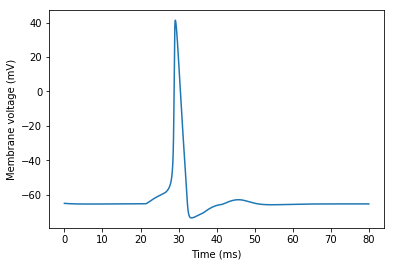

In [59]:
iclamp.amp = 0
neuron.h.tstop = 80

# Explain name ExpSyn
# Explain netstim -> other cell
# Explain all the field

netstim = neuron.h.NetStim()
netstim.interval = 5
netstim.number = 5
netstim.start = 20
netstim.noise = 0
netcon = neuron.h.NetCon(netstim, expsyn)
netcon.weight[0] = 1.0 # why [0] ?
neuron.h.run()

# Convert the NEURON vectors to numpy arrays
time_py = time.to_python()
voltage_py = voltage.to_python()

plot_tv(time_py, voltage_py)

del netstim
del netcon

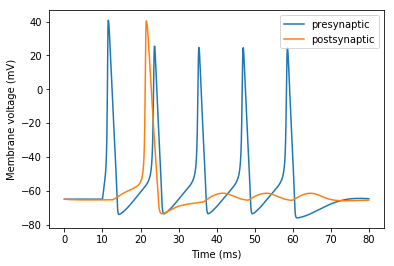

In [60]:
soma2 = neuron.h.Section(name='soma')
soma2.L = 40
soma2.diam = 40
soma2.insert('hh')


iclamp2 = neuron.h.IClamp(.5, sec=soma2)
iclamp2.amp = 1.0 # nA
iclamp2.delay = 10 # ms
iclamp2.dur = 50 # ms

time2 = neuron.h.Vector()
voltage2 = neuron.h.Vector()

time2.record(neuron.h._ref_t)
voltage2.record(soma2(.5)._ref_v);

expsyn.tau = .9
netcon2 = neuron.h.NetCon(soma2(.5)._ref_v, expsyn, sec=soma2)
netcon2.weight[0] = 1 # why [0] ?

neuron.h.run()

time_py = time.to_python()
voltage_py = voltage.to_python()

time2_py = time2.to_python()
voltage2_py = voltage2.to_python()

plot_tv(time2, voltage2, show=False, label='presynaptic')
plot_tv(time_py, voltage_py, show=False, label='postsynaptic')
plt.legend()
plt.show()

del netcon2